# Stochastic Block Model with Poisson/Gamma observations

## Description
We are trying to do analysis on a weighted (positive integer weights), undirected network on interactions between characters in Game of Thrones using a Stochastic Block Model, see http://mikkelschmidt.dk/papers/schmidt2013spm.pdf, section II.a.1), 




The usually imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd
import networkx as nx

plt.style.use('ggplot')
%matplotlib inline

## Data import
Import of the datafiles. The contents of the dataset can be seen in the intial initial_notebook.

In short the data concist of an undireced netwwork between persons in the TV series games of thrones. 

We want to infer communities in the network based on the observed edges in the network. The observed data is represented through the adjacency matrix of the network of size $N \times N$ such that N is the observed number of nodes (ie. characters). Then $X[i,j] = w$ is the observed number of interactions, w, between character i and j. $X$ is symmetric, as the network is undirected.

In [14]:
# load nodes and edges from file
nodes = pd.read_csv('../data/got-s6-nodes.csv')
edges = pd.read_csv('../data/got-s6-edges.csv')

# initialize networkx graph object and add nodes and edges
G = nx.Graph(name='Game Of Thrones S06')
G.add_nodes_from(nodes['Id'])
edge_dict = [(x['Target'],x['Source'], {'weight' : x['Weight']}) for (_,x) in edges.iterrows()]
G.add_edges_from(edge_dict)

# Modelling

As mentioned above we will fit a Stochastic Block Model (SBM) to the Game of Thrones data. The SBM is a mixture model where we assume that each node belongs to a single mixture component. Since each edge connects two nodes its likelyhood will depend on the corresponding two mixture components. We let $N$ denote the number of nodes and $K$ denote the number of mixture components

We assume that the edges are i.i.d and hence get that the likelyhood of the network takes the form:
$$ p(X,\theta) = \prod_{i,j} p(x_{i,j}|z_i, z_j, \phi) $$
Where $\theta = \{ \{z_i \}_{i=1}^N, \phi\}$. Here $z_i$ indicates which mixture component the $i$th node belongs to and $\phi$ denotes any further parameters depending on the distribution. 
A simple choice of distribution would be a Poisson distribution. Then each probability in the product would be
$$ p(x_{i,j} | z_i, z_j, \lambda) = Poisson(\lambda_{i,j})  $$
Where $\lambda$ is a matrix with the rates between groups s.t. $\lambda_{i,j}$ is the rate between rate $i$ and $j$. We choose to assume that $\lambda_{i,j} \sim Gamma(a,b)$ where $a$ and $b$ are chosen hyperparameters.
Next we assume the node mixture indicators $z$ to come from a $K$-dimensional categorical distribution
$$ p(z_i = k | \pi) = \pi_k  $$
where $\pi = \{ \pi_k\}_{k=1}^K$ and $\sum_{k=1}^k pi_k = 1$. We assume that $\pi$ is Dirichlet distributed with prior $\alpha$

From the above modelling we get the following generative process:
* Given parameters $a$, $b$ and $\alpha$
    1. draw $\pi \sim Dirichlet(\alpha)$
    2. for $n = 1..N$
        * draw $z_i \sim Categorical(\pi)$
    3. draw $\lambda \sim Gamma(a,b)$
    4. for all $i,j$ where $i \neq j$
        * draw $x_{i,j} \sim Poisson(\lambda_{i,j})$

Which can also be depicted in the a PGM:

![PGM1](https://i.imgur.com/tLcH5KT.png)

However as STAN does not do well with discrete variables we cannot directly infer $z$ in the above model. This is a well known shortcoming STAN well documented in chapter 5 of the 'STAN User's Guide'. The work around is marginalizing out the discrete variables in the likelyhood by summing:

$$ p(X_{i,j}|\lambda) = \sum_{k=1}^K \sum_{k'=1}^K \text{Categorical}(z_i = k|\lambda)\text{Categorical}(z_j = k'|\lambda)\text{Poisson}(X_{ij}| \lambda_{k,k'})    $$

In the implementation in STAN we transfer the above to the log scale for numerical reasons.

Below is an implementation in STAN where we infer $\lambda$ in the above model using the marginalization work around.

The next step is we want to get the mixture components for each node $z_i$ out. To do this we will follow the STAN user guide example given here: https://mc-stan.org/docs/2_18/stan-users-guide/summing-out-the-responsibility-parameter.html.

We want the probability that a node is in a given group given the data. This is still a work in progress, but so far we have
$ p(z_n = k_1 |X, \pi, \lambda) = \frac{\prod_{i=1}{N}(\prod_{k_2=1}^K(p(x_{i,n} | z_n = k_1, z_i = k_2, \lambda)p(z_i = k_2 | \pi))p(z_n = k_1 | \pi)}{\sum_{k_1=1}^K(\prod_{i=1}{N}(\prod_{k_2=1}^K(p(x_{i,n} | z_n = k_1, z_i = k_2, \lambda)p(z_i = k_2 | \pi))p(z_n = k_1 | \pi)} $

By putting in the distributions and converting to the log scale we should be able to implement this into STAN in the "generated quantiles" code block.

In [30]:
model_code="""
data {
        int<lower=1> N; // number of nodes
        int X[N,N]; // adjacency matrix
        int<lower=2> K; // number of groups
        vector[K] alpha; // prior for dirichlet distribution
        real a;          // priors on lambda
        real b;
} parameters {
        //int z[N]; // group belonging, encoded as integers - we cannot do this as z is integer latent variable!
        simplex[K] pi; // group sizes
        cov_matrix[K] lambda; // rates between groups

} model {
        matrix[K,K] log_mix_prop; // log mixing proportions
        matrix[K,K] lps;
        
        pi ~ dirichlet(alpha); // prior on group sizes
        for (k1 in 1:K){
            for (k2 in 1:K) {
                lambda[k1,k2] ~ gamma(a,b);
            }
        }
        // cache mixing proportions
        for (k1 in 1:K) {
            for (k2 in 1:K) {
                log_mix_prop[k1, k2] = log(pi[k1]) + log(pi[k2]);
            }
        }
        
        // likelihood
        for (i in 1:N) {
            for (j in 1:N) {
                if (i == j) continue; // ignore diagonal
                
                lps = log_mix_prop; // reset log probs
                for (k1 in 1:K) {
                    for (k2 in 1:K) {
                        lps[k1, k2] += poisson_lpmf(X[i,j] | lambda[k1,k2]);
                    }
                }
                target += log_sum_exp(lps);
            }
        }
        
        
}
"""

In [31]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5df27da6e569240baae6eae42bf815c8 NOW.
C:\Users\Mathias N Tygesen\Miniconda3\envs\dtu\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\MATHIA~1\AppData\Local\Temp\tmpghidx6wy\stanfit4anon_model_5df27da6e569240baae6eae42bf815c8_5214146098149202951.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


[[  0 109 102 ...   0   0   5]
 [109   0  83 ...   0   0   0]
 [102  83   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   8   2]
 [  0   0   0 ...   8   0   9]
 [  5   0   0 ...   2   9   0]]


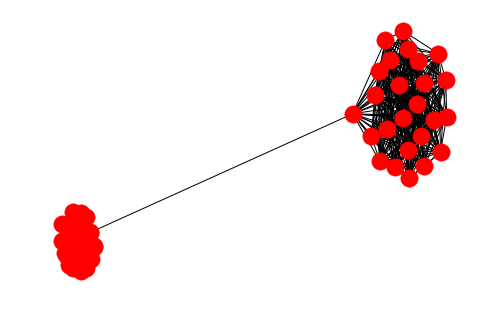

In [32]:
# Generate small network to test on

num_each = 50
G = nx.barbell_graph(num_each,0)
#nx.draw(G)

mat = nx.to_numpy_array(G, dtype=int)
rate1 = 100
rate2 = 8
mat1 = np.random.poisson(rate1, size=(num_each//2, num_each//2))
mat1 = np.tril(mat1) + np.tril(mat1,k=-1).T
mat2 = np.random.poisson(rate2, size=mat1.shape)
mat2 = np.tril(mat2) + np.tril(mat2, k=-1).T

mat = np.array(np.block([[mat1, np.zeros(mat1.shape, dtype=int)], [np.zeros(mat1.shape, dtype=int), mat2]]))
np.fill_diagonal(mat, 0)
mat[0,-1] = mat[-1,0] = np.random.poisson(8)


print(mat)
G = nx.from_numpy_array(mat)
nx.draw(G)

In [ ]:
data = {'X' : mat, 'N' : mat.shape[0], 'K' : 2, 'alpha' : np.ones(2), 'a' : 7.5, 'b' : 1}
fit = sm.sampling(data=data, iter=10000, chains=1)

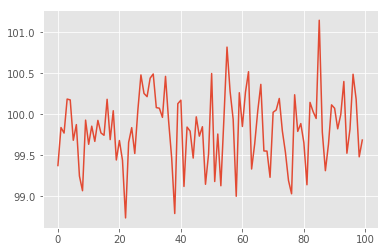

In [25]:
samples = fit.extract()
lambda_trace = samples['lambda']
plt.plot(lambda_trace[-100:,1,1])